# Getting Started with Chronos-2

**Chronos-2** is a foundation model for time series forecasting that builds on [Chronos](https://arxiv.org/abs/2403.07815) and [Chronos-Bolt](https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/). It offers significant improvements in capabilities and can handle diverse forecasting scenarios not supported by earlier models.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |

🧩 Chronos/Chronos-Bolt do not natively support future covariates, but they can be combined with external covariate regressors (see [AutoGluon tutorial](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html#incorporating-the-covariates)). This only models per-timestep effects, not effects across time. In contrast, Chronos-2 supports all covariate types natively.

More details about Chronos-2 are available in the [technical report](https://www.arxiv.org/abs/2510.15821).

In [1]:
%pip install -U 'chronos-forecasting>=2.0' 'pandas[pyarrow]' 'matplotlib'

In [2]:
# Use only 1 GPU if available
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("s3://autogluon/chronos-2/", device_map="cuda")

## Ecoli Forecasting

We start with a simple univariate forecasting example using the pandas API.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Load data as a long-format pandas data frame
file_path = "/content/drive/MyDrive/Ecoli data/exp1224.csv"
context_df = pd.read_csv(file_path)
print("Input dataframe shape:", context_df.shape)
display(context_df.head())

Input dataframe shape: (790, 1807)


,rihC,ypfH,alsI,ygdQ,yabP,ypfJ,talB,yqeI,yabI,hda,...,rpoD,fimD,lacZ,yacH,U66,serA,U139,tdcG_2,infA,yebF
0,-0.022629,0.148508,-0.088955,-0.232066,0.069350,-0.644056,-0.030329,-0.020271,0.158288,1.246769,...,-0.084612,-0.012124,-0.064123,-0.065857,-0.063226,2.938553,-0.079553,-0.094431,-3.164757,-0.242952
1,-0.075618,-0.191642,-0.041127,0.221798,0.114038,-0.554063,-0.029043,0.117677,0.020580,1.160078,...,-0.051237,-0.009570,-0.067436,-0.047152,-0.096200,3.144924,-0.022218,-0.034728,-1.831284,0.094008
2,0.053473,0.146480,-0.111173,0.138315,0.002590,-0.147216,-0.113246,-0.030373,0.089998,1.312099,...,-0.020321,-0.031348,-0.067067,0.027820,-0.080628,3.385740,-0.017088,-0.034646,-3.035438,-0.126263
3,-0.137537,-0.224630,-0.055299,0.019529,0.085433,-0.508369,0.011168,-0.104683,0.235458,0.657336,...,-0.018129,-0.012545,-0.007957,-0.086683,-0.067020,2.658177,-0.048128,-0.101937,-2.332679,0.168084
4,-0.001089,0.149665,0.019627,0.292656,-0.153317,-0.116954,-0.076620,-0.048036,0.044441,1.461989,...,-0.072185,-0.016076,-0.097118,-0.055341,-0.110282,2.639522,-0.048160,-0.161916,-1.510021,0.566953


In [33]:
# Transform the DataFrame to a NumPy array for multivariate forecasting
# The desired shape is (batch_size, num_variates, history_length)
# Here, each row is a time series and each column is a variate.
# We need to transpose the data and add a batch dimension of size 1

prediction_length = 48
context_array = context_df.iloc[:, :10].values.T[np.newaxis, :, :- prediction_length]
prediction_array = context_df.iloc[:, :10].values.T[np.newaxis, :,- prediction_length:]

print("Context array shape:", context_array.shape)
print("Prediciton array shape:", prediction_array.shape)

Context array shape: (1, 10, 742)
Prediciton array shape: (1, 10, 48)


In [34]:
# Generate multivariate forecasts using the numpy array
quantiles, mean = pipeline.predict_quantiles(
    context_array, prediction_length=48, quantile_levels=[0.1, 0.5, 0.9]
)
print("Multivariate output shapes:", quantiles[0].shape, mean[0].shape)

Multivariate output shapes: torch.Size([10, 48, 3]) torch.Size([10, 48])


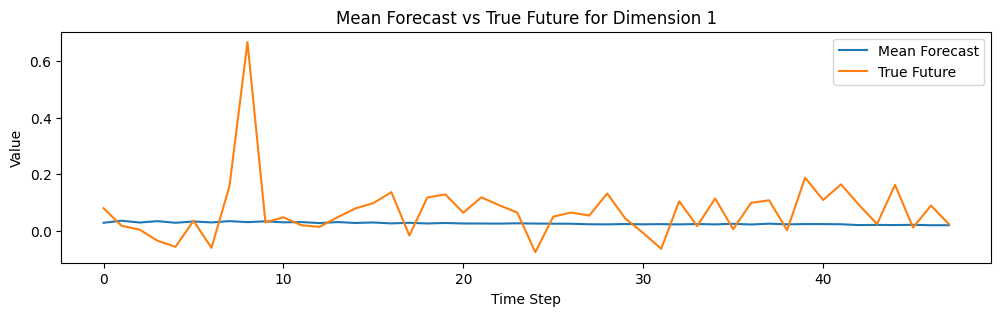

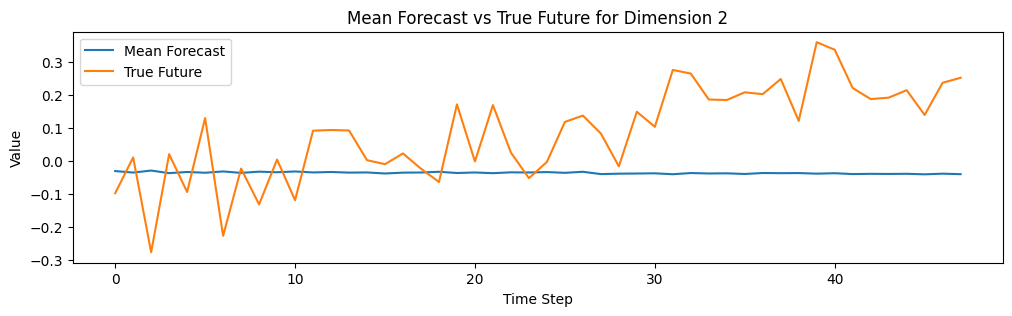

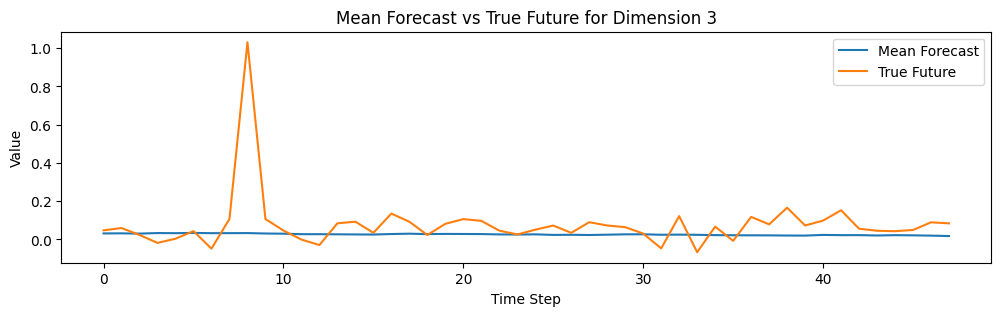

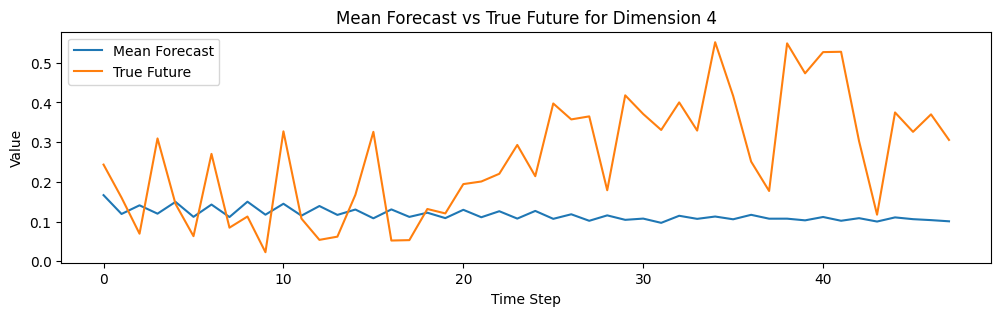

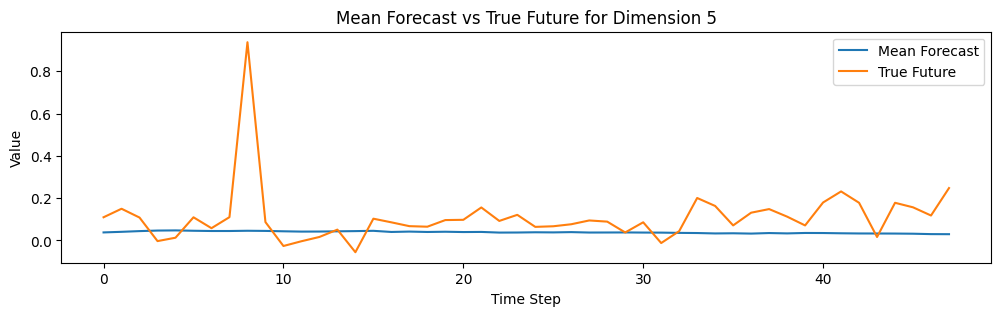

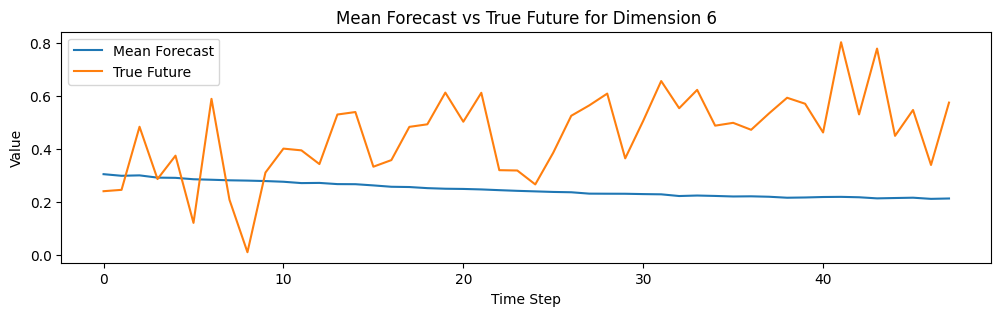

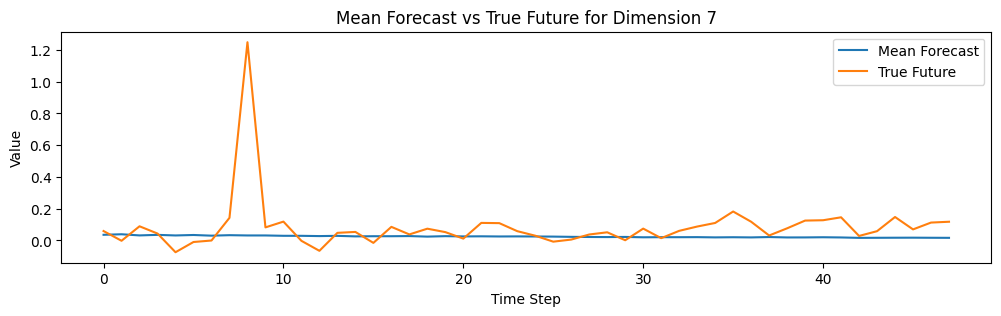

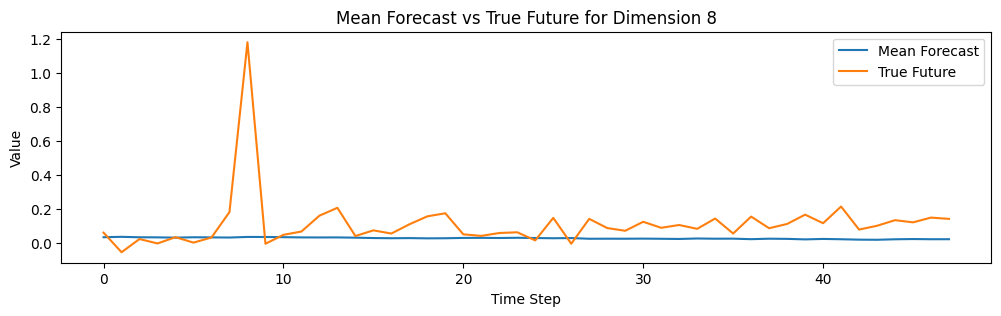

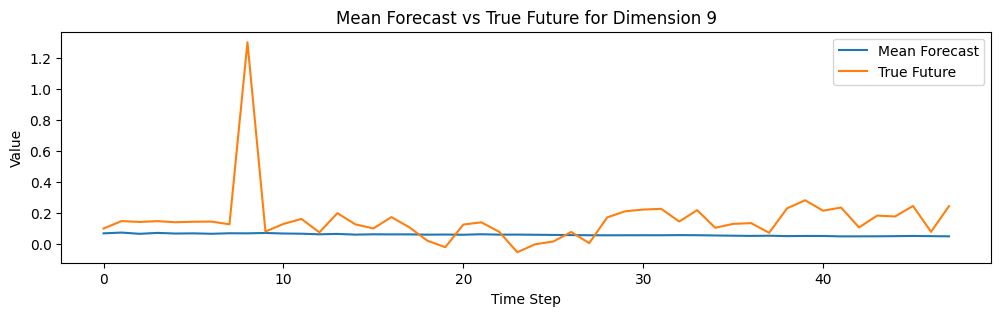

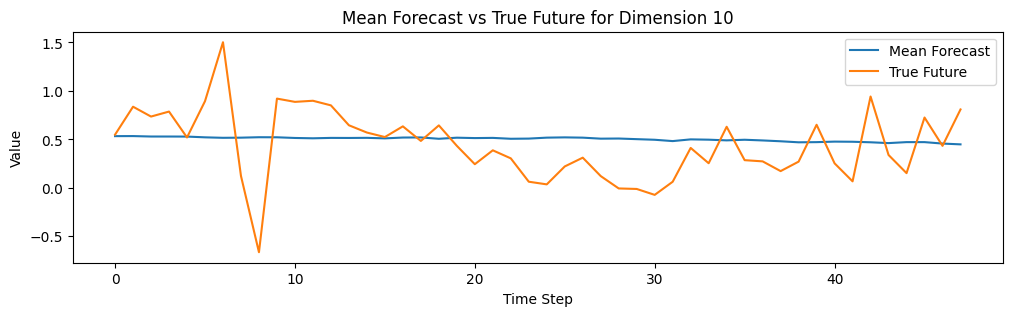

In [35]:
# Plot the mean forecast for each dimension and the true future values
num_variates = mean[0].shape[0]
prediction_length = mean[0].shape[1]

for i in range(num_variates):
    plt.figure(figsize=(12, 3))
    plt.plot(mean[0][i].cpu().numpy(), label="Mean Forecast")
    plt.plot(prediction_array[0][i], label="True Future")
    plt.title(f"Mean Forecast vs True Future for Dimension {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

## (Experimental) Fine-Tuning

Chronos-2 supports fine-tuning on your own data. This is an experimental feature that may change in future versions.

### Fine-Tuning API

The `fit` method accepts:
- `inputs`: Time series for fine-tuning (same format as predict_quantiles)
- `prediction_length`: Forecast horizon for fine-tuning
- `validation_inputs`: Optional validation data (same format as inputs)
- `learning_rate`: Optimizer learning rate (default: 1e-5)
- `num_steps`: Number of training steps (default: 1000)
- `batch_size`: Batch size for training (default: 256)

Returns a new pipeline with the fine-tuned model.

In [39]:
# Fine-tune the model
finetuned_pipeline = pipeline.fit(
    inputs=context_array,
    prediction_length=13,
    num_steps=50,  # few fine-tuning steps for a quick demo
    learning_rate=1e-5,
    batch_size=32,
    logging_steps=5,
)

/tmp/ipython-input-1198422955.py:2: FutureWarning: Fine-tuning support is experimental and may be changed in future versions.
  finetuned_pipeline = pipeline.fit(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
5,4.455800
10,4.915500
15,5.342300
20,4.594000
25,4.737500
30,4.725900
35,4.944100
40,4.436100
45,5.036700
50,4.518500


In [40]:
# Generate multivariate forecasts using the numpy array
quantiles, mean = finetuned_pipeline.predict_quantiles(
    context_array, prediction_length=48, quantile_levels=[0.1, 0.5, 0.9]
)
print("Multivariate output shapes:", quantiles[0].shape, mean[0].shape)

Multivariate output shapes: torch.Size([10, 48, 3]) torch.Size([10, 48])


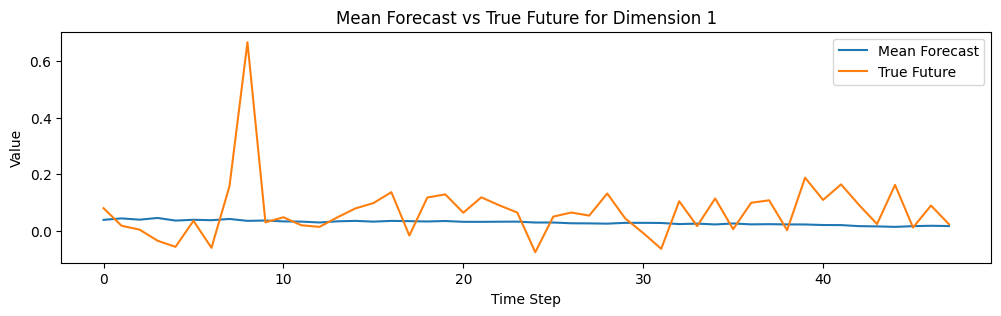

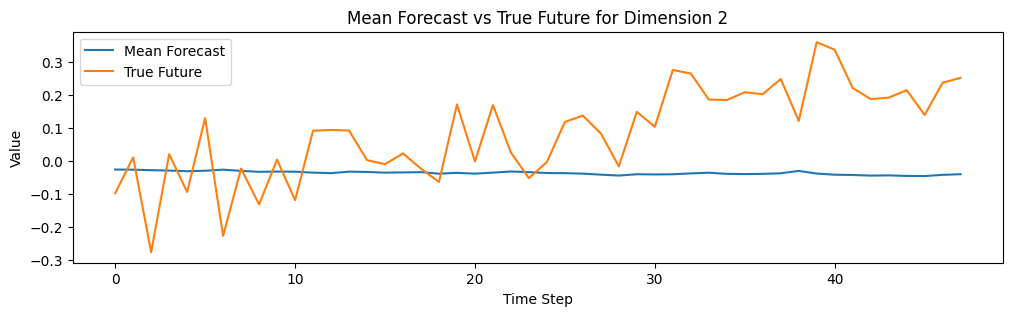

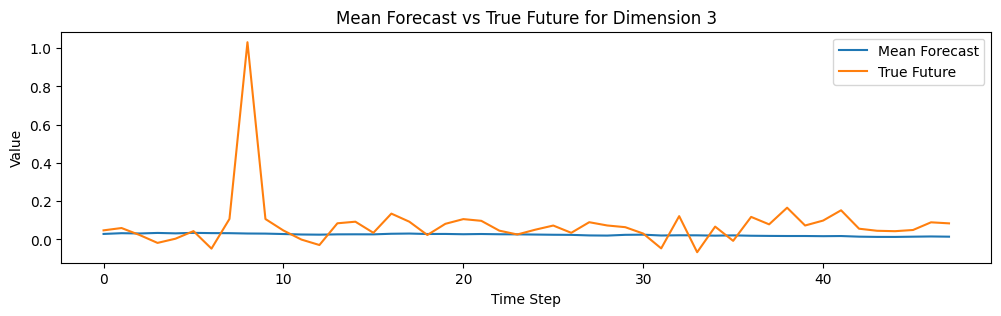

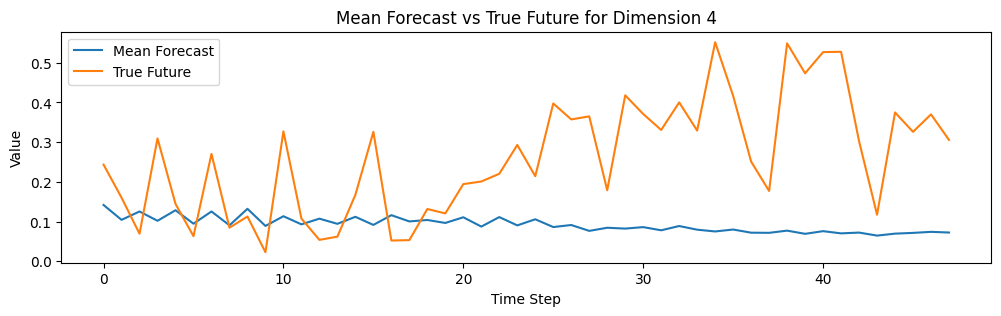

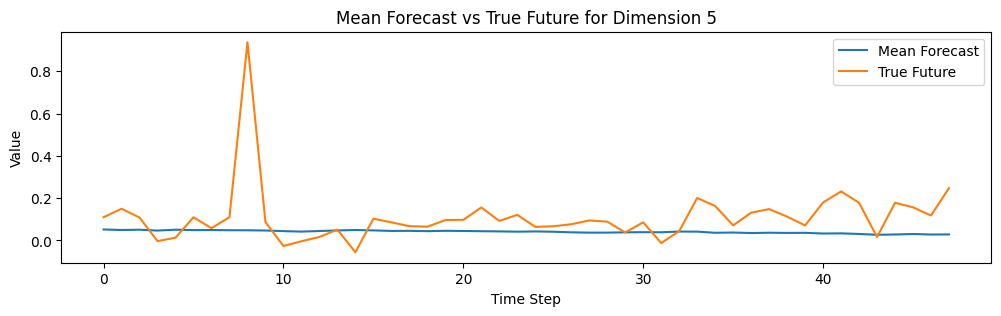

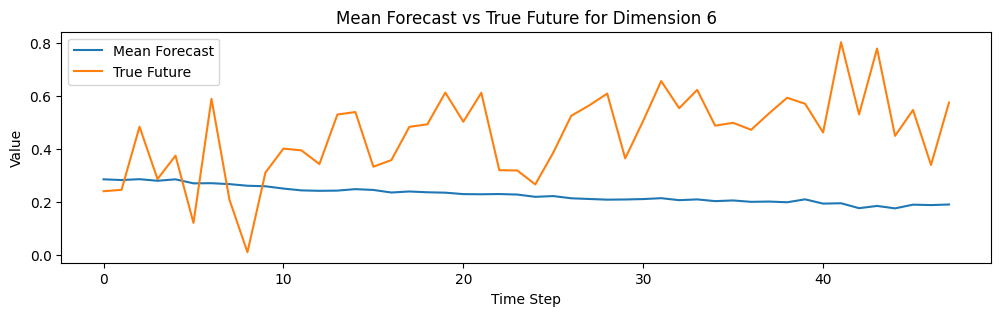

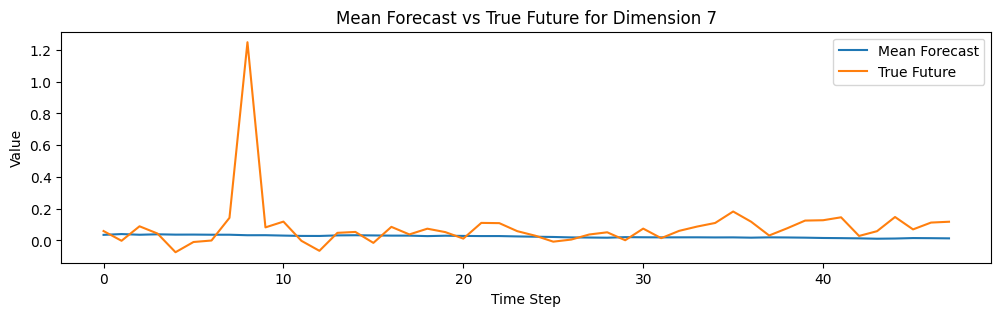

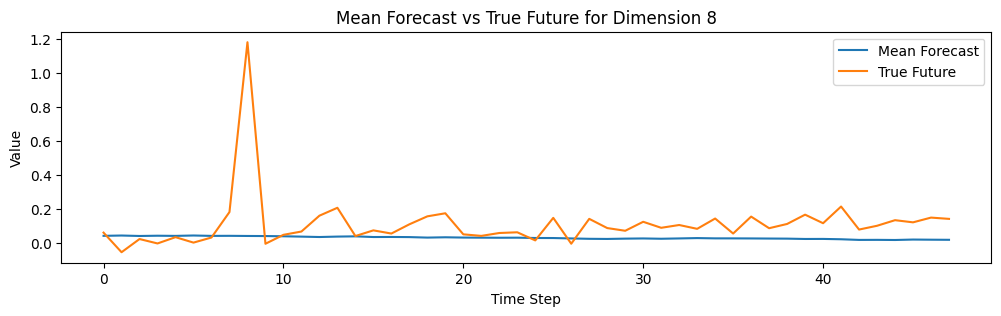

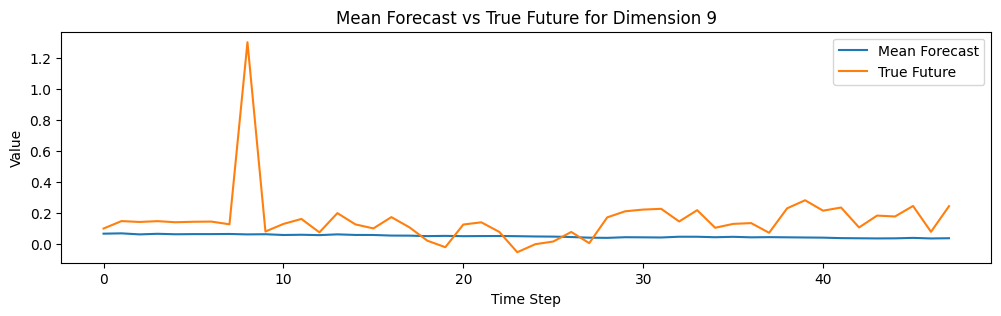

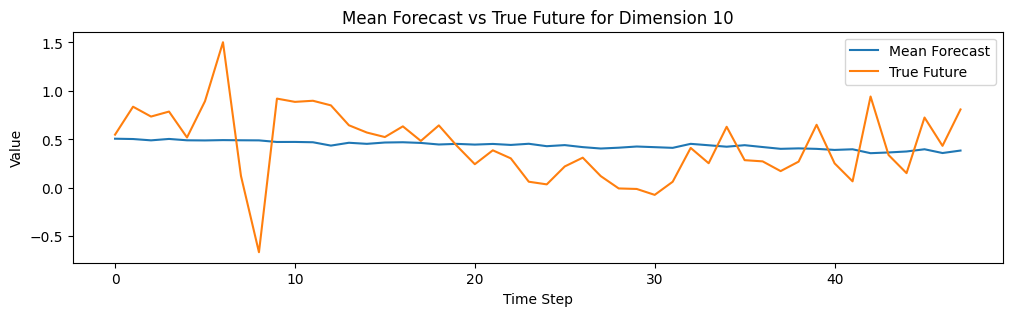

In [41]:
# Plot the mean forecast for each dimension and the true future values
num_variates = mean[0].shape[0]
prediction_length = mean[0].shape[1]

for i in range(num_variates):
    plt.figure(figsize=(12, 3))
    plt.plot(mean[0][i].cpu().numpy(), label="Mean Forecast")
    plt.plot(prediction_array[0][i], label="True Future")
    plt.title(f"Mean Forecast vs True Future for Dimension {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

**Note:** Fine-tuning is experimental functionality intended for advanced users. The default fine-tuning hyperparameters may not always improve accuracy for your specific use case.

# Task
Modify the code to split the `context_array` into `context_array_train` and `true_future_array`, then update the plotting function to compare the model's mean prediction with the `true_future_array`.